In [10]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

MYPROJECT='/Users/erotundo/PycharmProjects/DatasetAnnotatorProj'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")

import django
django.setup()

from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q, F
from django.db.models import Count, Sum, Max, Avg
from django.db.models import When, Case, Value
from django.db.models import IntegerField, FloatField
import numpy as np
import pandas as pd
from django.db.models.functions import Greatest, Coalesce, Lower

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# community selection
available_dbs = settings.DATABASES.keys()[1:]
db = 'travel'


sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = MYPROJECT + '/AnalysisQuality/output/' + db + '/'
PLOTS_FORMATS = ['.pdf', '.png']

# Threads length (all data)

In [2]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    
        
    # STAGE 1: considering (only) actual threads (later must sum 1 for the question)
    threads_length[db] = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values('parentid')\
        .annotate(thread_len_part=Count('parentid'))\
        .values_list('thread_len_part', flat=True)
    # adding 1 to count the question
    threads_length[db] = [x+1 for x in threads_length[db]]
    
    
    # STAGE 2: considering (only) unanswered questions
    # get ids of questions with answers
    parent_questions_ids = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values_list('parentid', flat=True)\
        .distinct()
    # count unanswered questions
    unanswered_q_count = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .exclude(id__in=parent_questions_ids)\
        .count()
    
    # append unanswered q to total counting
    threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]

# Thread length VS Nr threads (all data)

In [3]:
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

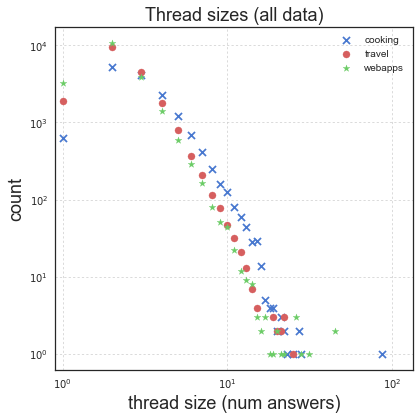

In [4]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], 
            y=t_length_count['cooking']['t_count'], 
            label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], 
            y=t_length_count['travel']['t_count'], 
            label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], 
            y=t_length_count['webapps']['t_count'], 
            label='webapps', s=50, c='g', marker='*', clip_on=False)

ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('Thread sizes (all data)', fontsize=18)
ax1.set_xlim(xmin=0.9)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes_ALL' + plot_format)

# Thread length VS Nr threads (annotated data)

In [5]:
# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    
        
    # STAGE 1: considering (only) actual threads (later must sum 1 for the question)
    
    # note: assumes question and all posts have been annotated (doesn't count answers not annotated)
    threads_length[db] = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                Q(annotatedqualitymarit__isnull=False) | \
                Q(annotatedqualitychristine__isnull=False) | \
                Q(annotatedqualityhenrik__isnull=False)) \
        .values('parentid')\
        .annotate(thread_len_part=Count('parentid'))\
        .values_list('thread_len_part', flat=True)
    # adding 1 to count the question
    threads_length[db] = [x+1 for x in threads_length[db]]
    
    
    # STAGE 2: considering (only) unanswered questions
    
    # get ids of questions with answers
    parent_questions_ids = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .values_list('parentid', flat=True)\
        .distinct()
    # count unanswered questions
    unanswered_q_count = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .exclude(id__in=parent_questions_ids)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                Q(annotatedqualitymarit__isnull=False) | \
                Q(annotatedqualitychristine__isnull=False) | \
                Q(annotatedqualityhenrik__isnull=False)) \
        .count()
    
    # append unanswered q to total counting
    threads_length[db] = threads_length[db] + [1 for i in range(unanswered_q_count)]
    
    
    
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

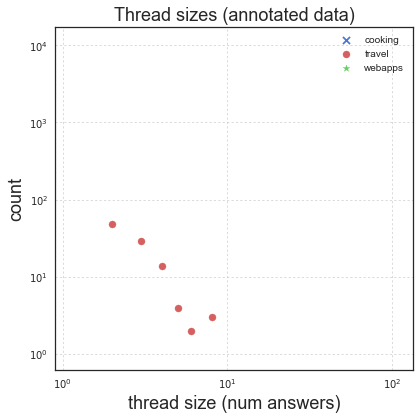

In [6]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], 
            y=t_length_count['cooking']['t_count'], 
            label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], 
            y=t_length_count['travel']['t_count'], 
            label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], 
            y=t_length_count['webapps']['t_count'], 
            label='webapps', s=50, c='g', marker='*', clip_on=False)


ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('Thread sizes (annotated data)', fontsize=18)
ax1.set_xlim(xmin=xmin, xmax=xmax)
ax1.set_ylim(ymin=ymin, ymax=ymax)


plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes_ANNOTATED' + plot_format)

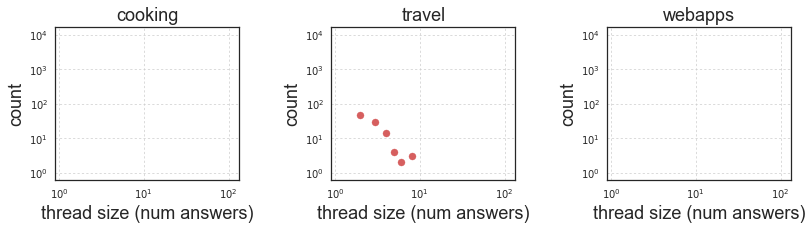

In [7]:
fig = plt.figure(figsize=(12,4))
plt.suptitle('Thread sizes (annotated data)', fontsize=18)

ax1 = fig.add_subplot(131)
ax1.scatter(x=t_length_count['cooking']['t_sizes'], 
            y=t_length_count['cooking']['t_count'], 
            label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('cooking', fontsize=18)
ax1.set_xlim(xmin=xmin, xmax=xmax)
ax1.set_ylim(ymin=ymin, ymax=ymax)
plt.grid(alpha=0.7, linestyle='dotted')
#plt.legend()

ax2 = fig.add_subplot(132)
ax2.scatter(x=t_length_count['travel']['t_sizes'], 
            y=t_length_count['travel']['t_count'], 
            label='travel', s=50, c='r', marker='o', clip_on=False)
ax2.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('travel', fontsize=18)
ax2.set_xlim(xmin=xmin, xmax=xmax)
ax2.set_ylim(ymin=ymin, ymax=ymax)
plt.grid(alpha=0.7, linestyle='dotted')
#plt.legend()

ax3 = fig.add_subplot(133)
ax3.scatter(x=t_length_count['webapps']['t_sizes'], 
            y=t_length_count['webapps']['t_count'], 
            label='webapps', s=50, c='g', marker='*', clip_on=False)
ax3.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.title('webapps', fontsize=18)
ax3.set_xlim(xmin=xmin, xmax=xmax)
ax3.set_ylim(ymin=ymin, ymax=ymax)
plt.grid(alpha=0.7, linestyle='dotted')
#plt.legend()

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'thread_sizes_perDB_ANNOTATED' + plot_format)

# Quality distribution VS Threads length

In [8]:
def mean_custon(q_q, a_q, thread_size):
    if (q_q is None and a_q is None):
        return None
    elif (q_q is None and a_q is not None):
        return q_q
    elif (q_q is not None and a_q is None):
        return a_q / float(thread_size)
    elif (q_q is not None and a_q is not None):
        return (q_q + a_q) / float(thread_size)
    

#  
"""
example: {'cooking':
            question_id: {
                    'thread_size: 4,
                    'thread_avg_quality: 1.3
                }
#         }
"""
threads_data = {
    'cooking': {},
    'webapps': {},
    'travel': {}
}


for db in available_dbs:
    #print db
        
    # STAGE 1: considering (only) actual threads
    
    questions = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .filter(Q(annotatedqualityenrico__isnull=False) |
                Q(annotatedqualitymarit__isnull=False) |
                Q(annotatedqualitychristine__isnull=False) |
                Q(annotatedqualityhenrik__isnull=False))\
        .values('id', 
                'answercount', 
                'annotatedqualityenrico')
       
    answers = Posts.objects\
        .using(db)\
        .filter(posttypeid=2)\
        .filter(Q(annotatedqualityenrico__isnull=False) |
                Q(annotatedqualitymarit__isnull=False) |
                Q(annotatedqualitychristine__isnull=False) |
                Q(annotatedqualityhenrik__isnull=False))\
        .values('parentid')\
        .annotate(sum_qual_enrico=Sum('annotatedqualityenrico'))
    
    for question in questions:
        threads_data[db][int(question['id'])] = {
            'thread_size': question['answercount'] + 1,
            'thread_avg_quality': question['annotatedqualityenrico']
        }
    
    for answer in answers:
        question_quality = threads_data[db][int(answer['parentid'])]['thread_avg_quality']
        thread_size = threads_data[db][int(answer['parentid'])]['thread_size']
        actual_average = mean_custon(question_quality, answer['sum_qual_enrico'], thread_size)
        threads_data[db][int(answer['parentid'])]['thread_avg_quality'] = actual_average
        
    #print threads_data[db]
    
    
    
# for each distinct value in [...] count its occurence, zip the result
"""
example:        {
                    'webapps': {
                        't_sizes': array([2,    3,  4,  5,  8]), 
                        't_count': array([29,   12, 7,  1,  1])
                        }, {...}
                }
"""
t_length_count = {}

for db in available_dbs:
    #print db
    t_lengths_list = [value['thread_size'] for key, value in threads_data[db].iteritems()]
    
    # count occurences
    bins = np.bincount(t_lengths_list)
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes,
        't_avg_qual': []
    }
    
    for size in t_sizes:
        avg_thread_sizes = []
        for key, value in threads_data[db].iteritems():
            if value['thread_size'] == size:
                avg_thread_sizes.append(value['thread_avg_quality'])
        t_length_count[db]['t_avg_qual'].append(avg_thread_sizes)

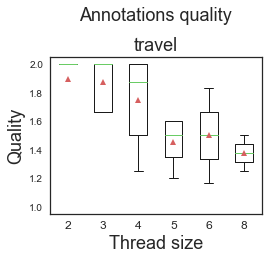

In [9]:
# some preprocessing here
bxplot_data = {}

for db in available_dbs:
    x_labels = t_length_count[db]['t_sizes']
    data = []
    for l in t_length_count[db]['t_avg_qual']:
        data_part = []
        for val in l:
            if val is not None:
                #print val
                data_part.append(val)
        data.append(data_part)
    bxplot_data[db] = {
        'data': data,
        'x_labels': x_labels
    }

plt.figure(figsize=(12, 4))
plt.suptitle('Annotations quality', fontsize=18)


flierprops = dict(marker='o', markerfacecolor='green', markersize=22,
                  linestyle='none')

"""
ax1 = plt.subplot(131)
db = 'cooking'
plt.boxplot(bxplot_data[db]['data'], notch=0, sym='+', vert=1, whis=1.5, showmeans=True)
plt.xlabel('Thread size', fontsize=18)
plt.ylabel('Quality', fontsize=18)
plt.title(db, fontsize=18)
xtickNames = plt.setp(ax1, xticklabels=np.repeat([str(x) for x in bxplot_data[db]['x_labels']], 1))
plt.setp(xtickNames, rotation=0, fontsize=12)
"""

ax1 = plt.subplot(132)
db = 'travel'
plt.boxplot(bxplot_data[db]['data'], notch=0, sym='+', vert=1, whis=1.5, showmeans=True)
plt.xlabel('Thread size', fontsize=18)
plt.ylabel('Quality', fontsize=18)
plt.title(db, fontsize=18)
xtickNames = plt.setp(ax1, xticklabels=np.repeat([str(x) for x in bxplot_data[db]['x_labels']], 1))
plt.setp(xtickNames, rotation=0, fontsize=12)

"""
ax1 = plt.subplot(133)
db = 'webapps'
plt.boxplot(bxplot_data[db]['data'], notch=0, sym='+', vert=1, whis=1.5, showmeans=True)
plt.xlabel('Thread size', fontsize=18)
plt.ylabel('Quality', fontsize=18)
plt.title(db, fontsize=18)
xtickNames = plt.setp(ax1, xticklabels=np.repeat([str(x) for x in bxplot_data[db]['x_labels']], 1))
plt.setp(xtickNames, rotation=0, fontsize=12)
"""
e
dplt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_quality_VS_thread_size' + plot_format)

# Annotations distribution

In [2]:
annotations_dist = dict()

for db in available_dbs:    
    # note: no need to remove -99 as at least one annotation is in [-1,0,1,2]
    annotations_dist[db] = Posts.objects.using(db) \
                            .filter(Q(annotatedqualityenrico__isnull=False) | \
                                Q(annotatedqualitymarit__isnull=False) | \
                                Q(annotatedqualitychristine__isnull=False) | \
                                Q(annotatedqualityhenrik__isnull=False)) \
                            .annotate(max=Greatest(
                                    Coalesce('annotatedqualityenrico', -99), 
                                    Coalesce('annotatedqualitymarit', -99),
                                    Coalesce('annotatedqualitychristine', -99),
                                    Coalesce('annotatedqualityhenrik', -99)))\
                            .values_list('max', flat=True)

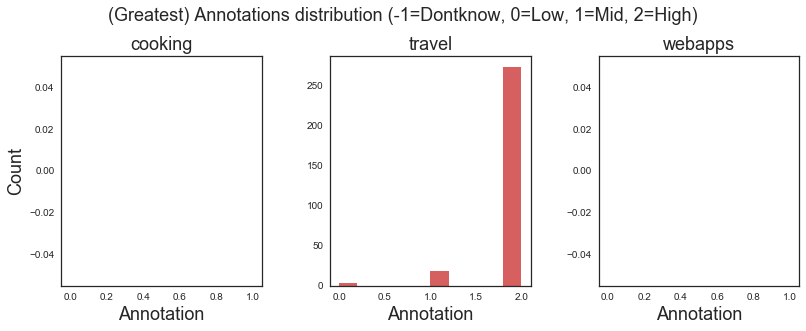

In [3]:
bins = 10
opacity = 1

plt.figure(figsize=(12,5))
plt.suptitle('(Greatest) Annotations distribution (-1=Dontknow, 0=Low, 1=Mid, 2=High)', fontsize=18)

ax = plt.subplot(131)
plt.hist(annotations_dist['cooking'], bins=bins, alpha=opacity, color='b', label='cooking')
plt.xlabel('Annotation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('cooking', fontsize=18)

plt.subplot(132)
plt.hist(annotations_dist['travel'], bins=bins, alpha=opacity, color='r', label='travel')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('travel', fontsize=18)

plt.subplot(133)
plt.hist(annotations_dist['webapps'], bins=bins, alpha=opacity, color='g', label='webapps')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('webapps', fontsize=18)

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_dist' + plot_format)

In [24]:
def full_agreement(a1,a2,a3,a4):
    if a1 == a2 == a3 == a4:
        return 2.0
    else:
        return 1.0
    
    
annotations_dist = dict()

for db in available_dbs:    
    # note: no need to remove -99 as at least one annotation is in [-1,0,1,2]
    annotations_dist[db] = Posts.objects.using(db) \
                            .filter(Q(annotatedqualityenrico__isnull=False) | \
                                Q(annotatedqualitymarit__isnull=False) | \
                                Q(annotatedqualitychristine__isnull=False) | \
                                Q(annotatedqualityhenrik__isnull=False)) \
                            .annotate(enrico=Coalesce('annotatedqualityenrico', -99),
                                     marit=Coalesce('annotatedqualitymarit', -99),
                                     christine=Coalesce('annotatedqualitychristine', -99),
                                     henrik=Coalesce('annotatedqualityhenrik', -99))\
                            .values_list('enrico', flat=True)

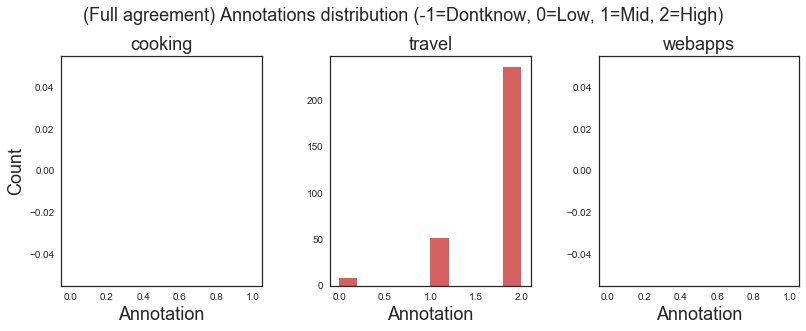

In [23]:
bins = 10
opacity = 1

plt.figure(figsize=(12,5))
plt.suptitle('(Full agreement) Annotations distribution (-1=Dontknow, 0=Low, 1=Mid, 2=High)', fontsize=18)

ax = plt.subplot(131)
plt.hist(annotations_dist['cooking'], bins=bins, alpha=opacity, color='b', label='cooking')
plt.xlabel('Annotation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('cooking', fontsize=18)

plt.subplot(132)
plt.hist(annotations_dist['travel'], bins=bins, alpha=opacity, color='r', label='travel')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('travel', fontsize=18)

plt.subplot(133)
plt.hist(annotations_dist['webapps'], bins=bins, alpha=opacity, color='g', label='webapps')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('webapps', fontsize=18)

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_dist' + plot_format)

In [25]:
def full_agreement(a1,a2,a3,a4):
    if a1 == a2 == a3 == a4:
        return 2.0
    else:
        return 1.0
    
    
annotations_dist = dict()

for db in available_dbs:    
    # note: no need to remove -99 as at least one annotation is in [-1,0,1,2]
    annotations_dist[db] = Posts.objects.using(db) \
                            .filter(Q(annotatedqualityenrico__isnull=False) | \
                                Q(annotatedqualitymarit__isnull=False) | \
                                Q(annotatedqualitychristine__isnull=False) | \
                                Q(annotatedqualityhenrik__isnull=False)) \
                            .annotate(enrico=Coalesce('annotatedqualityenrico', -99),
                                     marit=Coalesce('annotatedqualitymarit', -99),
                                     christine=Coalesce('annotatedqualitychristine', -99),
                                     henrik=Coalesce('annotatedqualityhenrik', -99))\
                            .values_list('marit', flat=True)

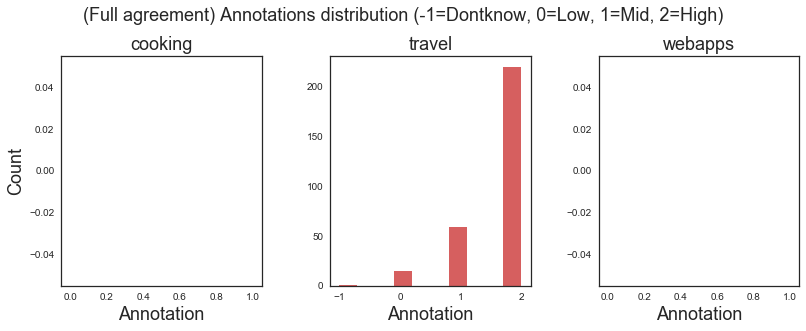

In [26]:
bins = 10
opacity = 1

plt.figure(figsize=(12,5))
plt.suptitle('(Full agreement) Annotations distribution (-1=Dontknow, 0=Low, 1=Mid, 2=High)', fontsize=18)

ax = plt.subplot(131)
plt.hist(annotations_dist['cooking'], bins=bins, alpha=opacity, color='b', label='cooking')
plt.xlabel('Annotation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('cooking', fontsize=18)

plt.subplot(132)
plt.hist(annotations_dist['travel'], bins=bins, alpha=opacity, color='r', label='travel')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('travel', fontsize=18)

plt.subplot(133)
plt.hist(annotations_dist['webapps'], bins=bins, alpha=opacity, color='g', label='webapps')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('webapps', fontsize=18)

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_dist' + plot_format)

In [27]:
def full_agreement(a1,a2,a3,a4):
    if a1 == a2 == a3 == a4:
        return 2.0
    else:
        return 1.0
    
    
annotations_dist = dict()

for db in available_dbs:    
    # note: no need to remove -99 as at least one annotation is in [-1,0,1,2]
    annotations_dist[db] = Posts.objects.using(db) \
                            .filter(Q(annotatedqualityenrico__isnull=False) | \
                                Q(annotatedqualitymarit__isnull=False) | \
                                Q(annotatedqualitychristine__isnull=False) | \
                                Q(annotatedqualityhenrik__isnull=False)) \
                            .annotate(enrico=Coalesce('annotatedqualityenrico', -99),
                                     marit=Coalesce('annotatedqualitymarit', -99),
                                     christine=Coalesce('annotatedqualitychristine', -99),
                                     henrik=Coalesce('annotatedqualityhenrik', -99))\
                            .values_list('christine', flat=True)

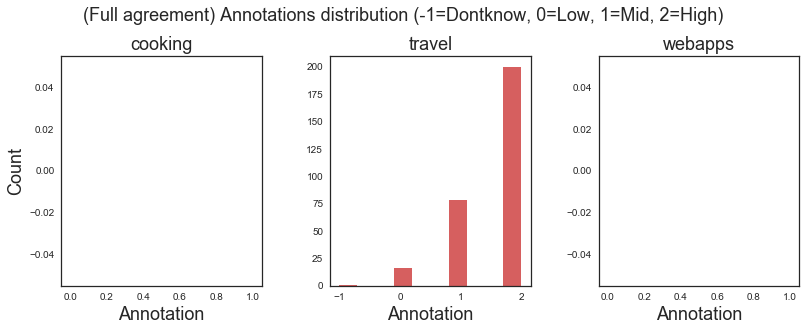

In [28]:
bins = 10
opacity = 1

plt.figure(figsize=(12,5))
plt.suptitle('(Full agreement) Annotations distribution (-1=Dontknow, 0=Low, 1=Mid, 2=High)', fontsize=18)

ax = plt.subplot(131)
plt.hist(annotations_dist['cooking'], bins=bins, alpha=opacity, color='b', label='cooking')
plt.xlabel('Annotation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('cooking', fontsize=18)

plt.subplot(132)
plt.hist(annotations_dist['travel'], bins=bins, alpha=opacity, color='r', label='travel')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('travel', fontsize=18)

plt.subplot(133)
plt.hist(annotations_dist['webapps'], bins=bins, alpha=opacity, color='g', label='webapps')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('webapps', fontsize=18)

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_dist' + plot_format)

In [29]:
def full_agreement(a1,a2,a3,a4):
    if a1 == a2 == a3 == a4:
        return 2.0
    else:
        return 1.0
    
    
annotations_dist = dict()

for db in available_dbs:    
    # note: no need to remove -99 as at least one annotation is in [-1,0,1,2]
    annotations_dist[db] = Posts.objects.using(db) \
                            .filter(Q(annotatedqualityenrico__isnull=False) | \
                                Q(annotatedqualitymarit__isnull=False) | \
                                Q(annotatedqualitychristine__isnull=False) | \
                                Q(annotatedqualityhenrik__isnull=False)) \
                            .annotate(enrico=Coalesce('annotatedqualityenrico', -99),
                                     marit=Coalesce('annotatedqualitymarit', -99),
                                     christine=Coalesce('annotatedqualitychristine', -99),
                                     henrik=Coalesce('annotatedqualityhenrik', -99))\
                            .values_list('henrik', flat=True)

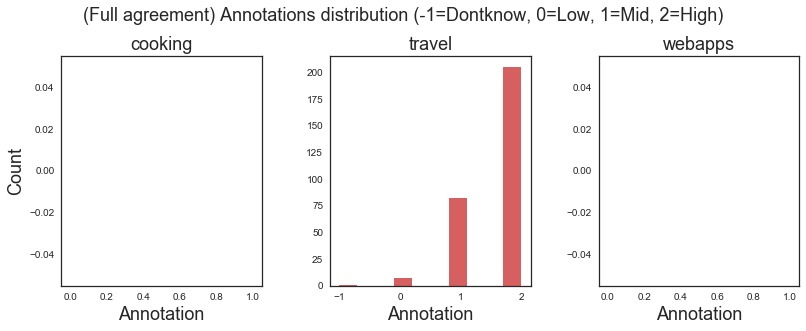

In [30]:
bins = 10
opacity = 1

plt.figure(figsize=(12,5))
plt.suptitle('(Full agreement) Annotations distribution (-1=Dontknow, 0=Low, 1=Mid, 2=High)', fontsize=18)

ax = plt.subplot(131)
plt.hist(annotations_dist['cooking'], bins=bins, alpha=opacity, color='b', label='cooking')
plt.xlabel('Annotation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('cooking', fontsize=18)

plt.subplot(132)
plt.hist(annotations_dist['travel'], bins=bins, alpha=opacity, color='r', label='travel')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('travel', fontsize=18)

plt.subplot(133)
plt.hist(annotations_dist['webapps'], bins=bins, alpha=opacity, color='g', label='webapps')
plt.xlabel('Annotation', fontsize=18)
#plt.ylabel('Count', fontsize=18)
plt.title('webapps', fontsize=18)

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'annotations_dist' + plot_format)

# Counting of questions/answers, per db

In [12]:
items_counting = {
    'whole_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    },
    'annotated_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    }
}

for db in available_dbs:
    # total nr of questions
    items_counting['whole_data'][db]['questions'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=1) \
            .count()

    # Total nr. of answers
    items_counting['whole_data'][db]['answers'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=2) \
            .count()

    # Total nr. of other posts
    items_counting['whole_data'][db]['other'] = \
        Posts.objects \
            .using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .count()

    # counting annotated questions
    items_counting['annotated_data'][db]['questions'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=1) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

    # counting annotated answers
    items_counting['annotated_data'][db]['answers'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

    # counting annotated others
    items_counting['annotated_data'][db]['others'] = \
        Posts.objects.using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

# whole_data
questions_whole_d = [items_counting['whole_data'][db]['questions'] for db in available_dbs]
answers_whole_d = [items_counting['whole_data'][db]['answers'] for db in available_dbs]
other_whole_d = [items_counting['whole_data'][db]['other'] for db in available_dbs]

# annotated_data
questions_ann_d = [items_counting['annotated_data'][db]['questions'] for db in available_dbs]
answers_ann_d = [items_counting['annotated_data'][db]['answers'] for db in available_dbs]
other_ann_d = [items_counting['annotated_data'][db]['other'] for db in available_dbs]

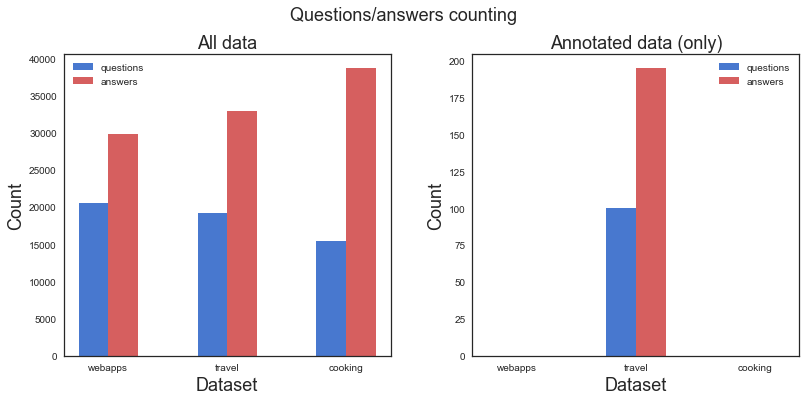

In [13]:
n_groups = 3
bar_width = 0.25
opacity = 1


# whole_data
plt.figure(figsize=(12,6))
plt.suptitle('Questions/answers counting', fontsize=18)
plt.subplot(121)
index = np.arange(n_groups)

plt.bar(index, questions_whole_d, bar_width, alpha=opacity, color='b', label='questions')
plt.bar(index + bar_width, answers_whole_d, bar_width, alpha=opacity, color='r', label='answers')
#plt.bar(index + bar_width*2, other_whole_d, bar_width, alpha=opacity, color='g', label='other')

plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('All data', fontsize=18)
plt.xticks(index + bar_width / 2, available_dbs)
plt.legend()


# annotated_data
plt.subplot(122)
index = np.arange(n_groups)

plt.bar(index, questions_ann_d, bar_width, alpha=opacity, color='b', label='questions')
plt.bar(index + bar_width, answers_ann_d, bar_width, alpha=opacity, color='r', label='answers')
#plt.bar(index + bar_width*2, other_ann_d, bar_width, alpha=opacity, color='g', label='other')

plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Annotated data (only)', fontsize=18)
plt.xticks(index + bar_width / 2, available_dbs)
plt.legend()
plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'QA_counting' + plot_format)

# Nr answers and nr questions, per user (all data)

In [14]:
# note: ids are non-negative integers
users_activity = {
    'whole_data': {
        'cooking': {
            # '1': {
            #     'nr_questions': -1,
            #     'nr_answers': -1
            # }   
        },
        'webapps': {},
        'travel': {}
    },
    'annotated_data': {
        'cooking': {},
        'webapps': {},
        'travel': {}
    }
}




for db in available_dbs:
    
    # whole_data
    
    # ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
    whole_d_vals = Posts.objects.using(db)\
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(
            nr_questions=Sum(
            Case(When(posttypeid=1, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField())),
            nr_answers=Sum(
            Case(When(posttypeid=2, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField()))
        )
    
    data = dict()
    for val in whole_d_vals:
        # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        if val['owneruserid'] >= 1:
            data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
    users_activity['whole_data'][db] = data
    
    
    # ONLY annotated_data
    
    # ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
    whole_d_vals = Posts.objects.using(db)\
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(
            nr_questions=Sum(
            Case(When(posttypeid=1, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField())),
            nr_answers=Sum(
            Case(When(posttypeid=2, then=Value(1)),
                 default=Value(0),
                 output_field=IntegerField()))
        )
    
    data = dict()
    for val in whole_d_vals:
        # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        if val['owneruserid'] >= 1:
            data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
    users_activity['annotated_data'][db] = data
    
    
# extract: each data point is a user, x is #questions, y is #answers

# whole data
whole_d_cooking = pd.DataFrame.from_dict(users_activity['whole_data']['cooking'], orient='index')
whole_d_travel = pd.DataFrame.from_dict(users_activity['whole_data']['travel'], orient='index')
whole_d_webapps = pd.DataFrame.from_dict(users_activity['whole_data']['webapps'], orient='index')
# annotated data
annotated_data_cooking = pd.DataFrame.from_dict(users_activity['annotated_data']['cooking'], orient='index')
annotated_data_travel = pd.DataFrame.from_dict(users_activity['annotated_data']['travel'], orient='index')
annotated_data_webapps = pd.DataFrame.from_dict(users_activity['annotated_data']['webapps'], orient='index')

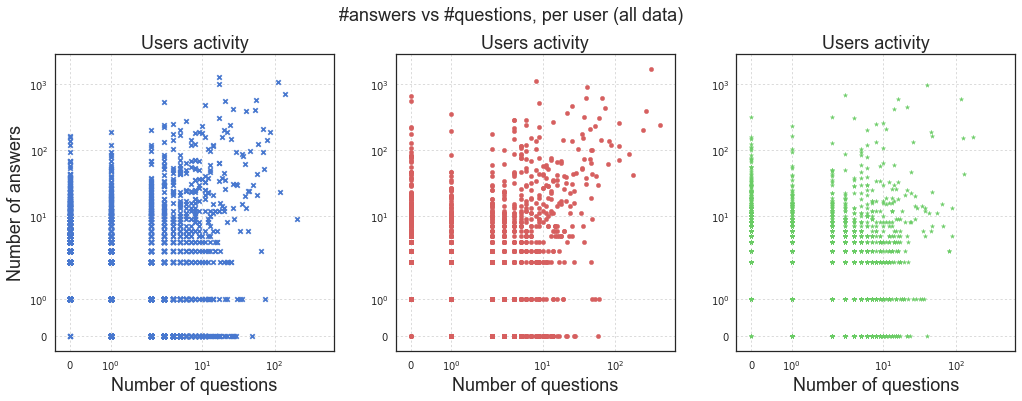

In [15]:
s=20

# scatter plots

fig = plt.figure(figsize=(15, 6))
fig.suptitle("#answers vs #questions, per user (all data)", fontsize=18)

ax1 = fig.add_subplot(131)
ax1.set_xscale('symlog', nonposx='clip')
ax1.set_yscale('symlog', nonposx='clip')
ax1.scatter(x=whole_d_cooking['nr_questions'], 
            y=whole_d_cooking['nr_answers'], 
            label='cooking', s=s, c='b', marker='x')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

ax2 = fig.add_subplot(132, sharey=ax1, sharex=ax1)
ax2.set_xscale('symlog', nonposx='clip')
ax2.set_yscale('symlog', nonposy='clip')
ax2.scatter(x=whole_d_travel['nr_questions'], 
            y=whole_d_travel['nr_answers'], 
            label='travel', s=s, c='r', marker='o')
plt.xlabel('Number of questions', fontsize=18)
#plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

ax3 = fig.add_subplot(133, sharey=ax1, sharex=ax1)
ax3.set_xscale('symlog', nonposx='clip')
ax3.set_yscale('symlog', nonposy='clip')
ax3.scatter(x=whole_d_webapps['nr_questions'], 
            y=whole_d_webapps['nr_answers'], 
            label='webapps', s=s, c='g', marker='*')
plt.xlabel('Number of questions', fontsize=18)
#plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_scatter_ALL' + plot_format)

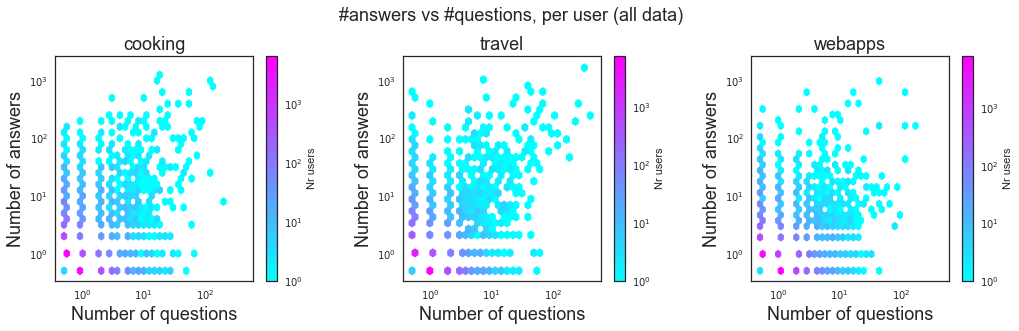

In [16]:
# hex bins

gridsize = 30

fig = plt.figure(figsize=(15, 5))
fig.suptitle("#answers vs #questions, per user (all data)", fontsize=18)

ax1 = fig.add_subplot(131, sharey=ax1, sharex=ax1)
hb = ax1.hexbin(x=whole_d_cooking['nr_questions'].replace(0, 0.5), 
                y=whole_d_cooking['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='cooking',
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax1.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax1)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('cooking', fontsize=18)


ax2 = fig.add_subplot(132,  sharey=ax1, sharex=ax1)
hb = ax2.hexbin(x=whole_d_travel['nr_questions'].replace(0, 0.5), 
                y=whole_d_travel['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='travel',
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax2.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('travel', fontsize=18)


ax3 = fig.add_subplot(133,  sharey=ax1, sharex=ax1)
hb = ax3.hexbin(x=whole_d_webapps['nr_questions'].replace(0, 0.5), 
                y=whole_d_webapps['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='webapps',
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax3.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax3)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('webapps', fontsize=18)


plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_2dhist_ALL' + plot_format)

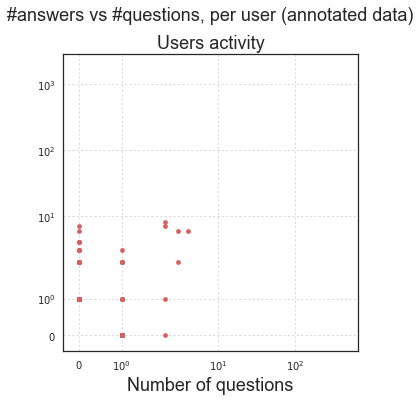

In [17]:
s=20

# scatter plots

fig = plt.figure(figsize=(15, 6))
fig.suptitle("#answers vs #questions, per user (annotated data)", fontsize=18)

"""
ax1 = fig.add_subplot(131, sharey=ax1, sharex=ax1)
ax1.set_xscale('symlog', nonposx='clip')
ax1.set_yscale('symlog', nonposx='clip')
ax1.scatter(x=annotated_data_cooking['nr_questions'], 
            y=annotated_data_cooking['nr_answers'], 
            label='cooking', s=s, c='b', marker='x')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')
"""

ax2 = fig.add_subplot(132, sharey=ax1, sharex=ax1)
ax2.set_xscale('symlog', nonposx='clip')
ax2.set_yscale('symlog', nonposy='clip')
ax2.scatter(x=annotated_data_travel['nr_questions'], 
            y=annotated_data_travel['nr_answers'], 
            label='travel', s=s, c='r', marker='o')
plt.xlabel('Number of questions', fontsize=18)
#plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')

"""
ax3 = fig.add_subplot(133, sharey=ax1, sharex=ax1)
ax3.set_xscale('symlog', nonposx='clip')
ax3.set_yscale('symlog', nonposy='clip')
ax3.scatter(x=annotated_data_webapps['nr_questions'], 
            y=annotated_data_webapps['nr_answers'], 
            label='webapps', s=s, c='g', marker='*')
plt.xlabel('Number of questions', fontsize=18)
#plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')
"""

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_scatter_ANNOTATED' + plot_format)

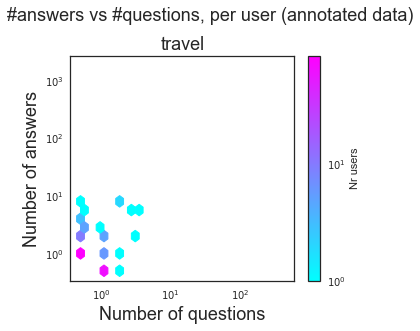

In [18]:
# hex bins

gridsize=8

fig = plt.figure(figsize=(15, 5))
fig.suptitle("#answers vs #questions, per user (annotated data)", fontsize=18)

"""
ax1 = fig.add_subplot(131, sharey=ax1, sharex=ax1)
hb = ax1.hexbin(x=annotated_data_cooking['nr_questions'].replace(0, 0.5), 
                y=annotated_data_cooking['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='cooking',
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax1.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax1)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('cooking', fontsize=18)
"""


ax2 = fig.add_subplot(132,  sharey=ax1, sharex=ax1)
hb = ax2.hexbin(x=annotated_data_travel['nr_questions'].replace(0, 0.5), 
                y=annotated_data_travel['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='travel',
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax2.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('travel', fontsize=18)


"""
ax3 = fig.add_subplot(133,  sharey=ax1, sharex=ax1)
hb = ax3.hexbin(x=annotated_data_webapps['nr_questions'].replace(0, 0.5), 
                y=annotated_data_webapps['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label='webapps',
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax3.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax3)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('webapps', fontsize=18)
"""

plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_2dhist_ANNOTATED' + plot_format)

# Question quality vs Answer quality

In [19]:
question_qual_vs_ans_qual = dict()

for db in [db]:
    
    threads_quality = dict()
    
    # counting
    questions_quality = Posts.objects.using(db) \
        .filter(posttypeid=1) \
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                Q(annotatedqualitymarit__isnull=False) | \
                Q(annotatedqualitychristine__isnull=False) | \
                Q(annotatedqualityhenrik__isnull=False)) \
        .values('id') \
        .annotate(question_quality=Greatest(
        Coalesce('annotatedqualityenrico', -99),
        Coalesce('annotatedqualitymarit', -99),
        Coalesce('annotatedqualitychristine', -99),
        Coalesce('annotatedqualityhenrik', -99)))

    answers_quality = Posts.objects.using(db) \
        .filter(posttypeid=2) \
        .filter(Q(annotatedqualityenrico__isnull=False) | \
                Q(annotatedqualitymarit__isnull=False) | \
                Q(annotatedqualitychristine__isnull=False) | \
                Q(annotatedqualityhenrik__isnull=False)) \
        .values('parentid') \
        .annotate(nr_answers_high=Sum(
            Case(
                When(annotatedqualityenrico__exact=2, then=1),
                When(annotatedqualitymarit__exact=2, then=1),
                When(annotatedqualitychristine__exact=2, then=1),
                When(annotatedqualityhenrik__exact=2, then=1),
                default=0,
                output_field=IntegerField())),
            nr_answers_mid=Sum(
            Case(
                When(annotatedqualityenrico__exact=1, then=1),
                When(annotatedqualitymarit__exact=1, then=1),
                When(annotatedqualitychristine__exact=1, then=1),
                When(annotatedqualityhenrik__exact=1, then=1),
                default=0,
                output_field=IntegerField())),
            nr_answers_low=Sum(
            Case(
                When(annotatedqualityenrico__exact=0, then=1),
                When(annotatedqualitymarit__exact=0, then=1),
                When(annotatedqualitychristine__exact=0, then=1),
                When(annotatedqualityhenrik__exact=0, then=1),
                default=0,
                output_field=IntegerField())),
            nr_answers_unknow=Sum(
            Case(
                When(annotatedqualityenrico__exact=-1, then=1),
                When(annotatedqualitymarit__exact=-1, then=1),
                When(annotatedqualitychristine__exact=-1, then=1),
                When(annotatedqualityhenrik__exact=-1, then=1),
                default=0,
                output_field=IntegerField()))
            )
    
    
    for thread in questions_quality:
        threads_quality[thread['id']] = {'question_quality': thread['question_quality']}
    for thread in answers_quality:
        threads_quality[thread['parentid']].update(
            {
                'nr_answers_high': thread['nr_answers_high'],
                'nr_answers_mid': thread['nr_answers_mid'],
                'nr_answers_low': thread['nr_answers_low'],
                'nr_answers_unknow': thread['nr_answers_unknow']
            })
        
    df = pd.DataFrame.from_dict(threads_quality, orient='index')
    

    
    df_summed = df.groupby('question_quality').sum()
    df_tot = df_summed.sum(axis='columns')
    df_divided = df_summed.divide(df_tot, axis='index') * 100
    #df_final = df_divided.append(df_tot / df_tot * 100, ignore_index=True)
    
 
    question_qual_vs_ans_qual[db] = df_divided

KeyError: 'question_quality'

In [ ]:
fields_list = list(reversed(['nr_answers_unknow','nr_answers_low', 'nr_answers_mid', 'nr_answers_high']))


fig = plt.figure(figsize=(15, 6))
fig.suptitle("Questions quality vs Answers quality (%)", fontsize=18)

"""
ax1 = fig.add_subplot(131)
sns.heatmap(question_qual_vs_ans_qual['cooking'][fields_list], annot=True, fmt = '.0f', cbar=False, ax=ax1)
for t in ax1.texts: t.set_text(t.get_text() + "%")
plt.ylabel('Questions quality', fontsize=18)
plt.xlabel('Answers quality', fontsize=18)
plt.title('cooking', fontsize=18)
"""

ax2 = fig.add_subplot(132,  sharey=ax1, sharex=ax1)
sns.heatmap(question_qual_vs_ans_qual['travel'][fields_list], annot=True, fmt = '.0f', cbar=False, ax=ax2)
for t in ax2.texts: t.set_text(t.get_text() + "%")
plt.ylabel('Questions quality', fontsize=18)
plt.xlabel('Answers quality', fontsize=18)
plt.title('travel', fontsize=18)

"""
ax3 = fig.add_subplot(133,  sharey=ax1, sharex=ax1)
sns.heatmap(question_qual_vs_ans_qual['webapps'][fields_list], annot=True, fmt = '.0f', cbar=False, ax=ax3)
for t in ax3.texts: t.set_text(t.get_text() + "%")
plt.ylabel('Questions quality', fontsize=18)
plt.xlabel('Answers quality', fontsize=18)
plt.title('webapps', fontsize=18)
"""

plt.tight_layout(pad=3)

for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'questions_quality_VS_answers_quality' + plot_format)